## INFO 2950 Final Project
### Introduction
**Research Questions:** 
1. Explore the socioeconomic and environmental features that best predict the incidents of hate crime incidents in the United States.
2. Investigate whether the addition of Covid-19 into our prediction model improves the model’s overall fitness.


In [65]:
import numpy as np
from numpy import sqrt, mean, absolute
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
import geopandas

### Exploratory Data Analysis
**Data Cleaning/Processing**
1. hate crime incidents
   
   *Clean Excel format* - Delete titles, merged cells, and footers; Renamed columns and indexes to a same standard across all years; Replace NaNs with zeros
   
   *Process* - Add [Incidents] column = the sum of all catogories of incidnets on that row; Add [Year] column; Drop all other columns except for [State]

In [66]:
# Import annual hate crime incidents df
years = np.linspace(2006, 2020, 15, dtype=int).tolist()
offenses =[]
for y in years:
    n = y - 2006
    offenses_path='./offenses_csv/%s.csv'%(y)
    offenses.append(pd.read_csv(offenses_path, thousands=','))
    
    # Add Year column
    offenses[n]['Year'] = y

# Combine all years' incidents data
df_off = pd.concat(offenses)

# Drop details because we only care about total
df_off = df_off[df_off['Agency type'] == 'Total']
df_off = df_off.drop(columns=['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Agency name', 'Agency type',
'1st\r\nquarter', '2nd\r\nquarter', '3rd\r\nquarter', '4th\r\nquarter','Unnamed: 3', 'Unnamed: 9', 'Agency unit', 'Population1'])

# Replace NaNs with zeros
df_off = df_off.replace(np.nan,0)

# Replace exisiting str zero with float
cat_list=['Race', 'Religion', 'Sexual_orientation', 'Ethnicity', 'Disability', 'Gender', 'Gender_identity', 'Race/Ethnicity/Ancestry']
df_off[cat_list] = df_off[cat_list].astype(int)

# Add up total incidents
df_off['Incidents'] = 0
for c in cat_list:
    df_off['Incidents'] += df_off[c]

# Get rid of categories because we only care about total
df_off = df_off.drop(columns=cat_list)

# Clean State format
df_off['State'] = df_off['State'].str.title()
df_off['Year'] = df_off['Year'].astype(str)
df_off = df_off.reset_index(drop=True)
df_off.to_csv('incidents.csv')
# df_off

2. population
   
   *Clean* - Combine data of 2001-2010 and 2010-2020
   
   *Process* - Select only total population; Drop subcatrgories; Melt wide [Year] to tidy (each rows represents one year one state)

In [67]:
pop1 = pd.read_csv('./pop1.csv', thousands=',')

# Trun wide df to tidy
pop1 = pd.melt(pop1, id_vars=['State'], value_vars=pop1.columns[1:], var_name='Year', value_name='Population')
# pop1

In [68]:
pop2 = pd.read_csv('./pop2.csv', thousands=',')

# Select totol by setting all categorical inputs to zero
col =['SEX', 'ORIGIN', 'RACE', 'AGEGRP']
for c in col:
    pop2 = pop2[pop2[c] == 0]

pop2 = pop2.drop(columns=col)
# Trun wide df to tidy
pop2 = pd.melt(pop2, id_vars=['State'], value_vars=pop2.columns[1:], var_name='Year', value_name='Population')
# pop2

In [69]:
# Combine population data (2010-2020) and (2000-2009)
df_pop = pd.concat([pop2, pop1])
df_pop.to_csv('population.csv')
# df_pop

3. GDP

   *Process* - melt wide [Year] to tidy (each rows represents one year one state)

In [70]:
df_gdp = pd.read_csv('./raw_gdp.csv', thousands=',')

# Trun wide df to tidy
df_gdp = pd.melt(df_gdp, id_vars=['State'], value_vars=df_gdp.columns[1:], var_name='Year', value_name='GDP')
df_gdp.to_csv('gdp.csv')
# df_gdp

4. avergae temperature
   
   *Clean* - Change column names to the same standard as above
   
   *Process* - Add [State] and [Year] column; Drop other columns; Combine all states' data

In [71]:
# read all csv in temperature folder
path = './avg_temp'
csv_files = glob.glob(path + '/*.csv')

dfs = []
for f in csv_files:
    df = pd.read_csv(f)

    # Get State column
    parts = f.split('/')
    part = parts[2].split('.')
    df['State'] = part[0]

    # Formatting 
    df['Temperature'] = df['Value']
    df['Year'] = (df['Date']/100).astype(int).astype(str)
    df = df.drop(columns=['Date', 'Value', 'Anomaly'])

    # Combine all avg_temp df
    dfs.append(df)

df_temp = pd.concat(dfs).reset_index(drop=True)
df_temp.to_csv('temperature.csv')
# df_temp

In [72]:
df_marr = pd.read_csv('./marr.csv', thousands=',')
df_marr['State'] = df_marr['Unnamed: 0']
df_marr = df_marr.drop(columns=['Unnamed: 0', 'Unnamed: 25'])
df_marr = df_marr.replace('---',0)
df_marr = pd.melt(df_marr, id_vars=['State'], value_vars=df_marr.columns[:-1], var_name='Year', value_name='Marriage_Rate')

def replace(s):
    df = df_marr.loc[df_marr['State']==s]
    df_ = df.reset_index(drop=True)
    reg = LinearRegression().fit(df[['Year']], df['Marriage_Rate'])
    pred = reg.predict(df[['Year']])
    big_l = df[df['Marriage_Rate']==0].index.to_list()
    small_l = df_[df_['Marriage_Rate']==0].index.to_list()

    for i, l in enumerate(big_l):
        df_marr.loc[l, 'Marriage_Rate'] = pred[small_l[i]]

states = ['Georgia', 'Louisiana', 'Oklahoma']
for s in states: replace(s)

df_marr['Year'] = df_marr['Year'].astype(str)
df_marr['Marriage_Rate'] = df_marr['Marriage_Rate'].astype(float)
df_marr.to_csv('marriage.csv')
df_marr.loc[df_marr['State']=='Oklahoma']

,State,Year,Marriage_Rate
36,Oklahoma,2020,5.900000
87,Oklahoma,2019,6.300000
138,Oklahoma,2018,6.400000
189,Oklahoma,2017,6.800000
240,Oklahoma,2016,6.700000
291,Oklahoma,2015,7.400000
342,Oklahoma,2014,7.100000
393,Oklahoma,2013,7.100000
444,Oklahoma,2012,6.900000
495,Oklahoma,2011,6.900000


In [73]:
df_edu = pd.read_csv('./edu.csv', thousands=',')
df_edu = pd.melt(df_edu, id_vars=['Year'], value_vars=df_edu.columns[1:], var_name='State', value_name='Education_Rate')
df_edu['Year'] = df_edu['Year'].astype(str)
# df_edu

Model DataFrame

- Combine four variables above
- *Transformation* - change population and GDP to log scale; add binary covid indicator

In [74]:
# Combine all input features and the output
df = df_pop.merge(df_gdp, on=['State', 'Year'])
df = df.merge(df_off, on=['State', 'Year'])
df = df.merge(df_temp, on=['State', 'Year'])
df = df.merge(df_marr, on=['State', 'Year'])
df = df.merge(df_edu, on=['State', 'Year'])
df['Year'] = df['Year'].astype(int)

# Log transformation
df['Log_Population'] = np.log(df['Population'])
df['Log_GDP'] = np.log(df['GDP'])

# Add covid indicator (binary)
df['Is_Covid'] = np.where(df['Year']==2020, 1, 0)
df.to_csv('model.csv')
df

,State,Year,Population,GDP,Incidents,Temperature,Marriage_Rate,Education_Rate,Log_Population,Log_GDP,Is_Covid
0,Alabama,2006,4628981,187270.8,1,64.2,9.2,26.9,15.347847,12.140311,0
1,Alaska,2006,675302,49190.2,6,26.4,8.2,21.1,13.422915,10.803450,0
2,Arizona,2006,6029141,274179.4,149,61.1,6.5,18.2,15.612115,12.521538,0
3,Arkansas,2006,2821761,108460.6,113,62.0,12.4,25.5,14.852872,11.594142,0
4,California,2006,36021202,2002437.4,1297,58.6,6.3,29.0,17.399618,14.509876,0
...,...,...,...,...,...,...,...,...,...,...,...
722,Virginia,2020,8590563,478909.3,170,57.4,5.3,42.1,15.966175,13.079267,1
723,Washington,2020,7693612,538856.1,462,48.1,4.8,38.4,15.855901,13.197204,1
724,West Virginia,2020,1784787,70444.2,54,54.0,5.6,31.8,14.394810,11.162576,1
725,Wisconsin,2020,5832655,293104.9,72,44.8,4.5,23.1,15.578983,12.588286,1


**Data Description**

- Grain (instance): each row represents per year and per state
- Limitations: Limited year range 2006 -2020; Replaced NaN with zero
- Output: Incidents; Inputs(Features): Temperature, Log_Population Log_GDP, Is_Covid 

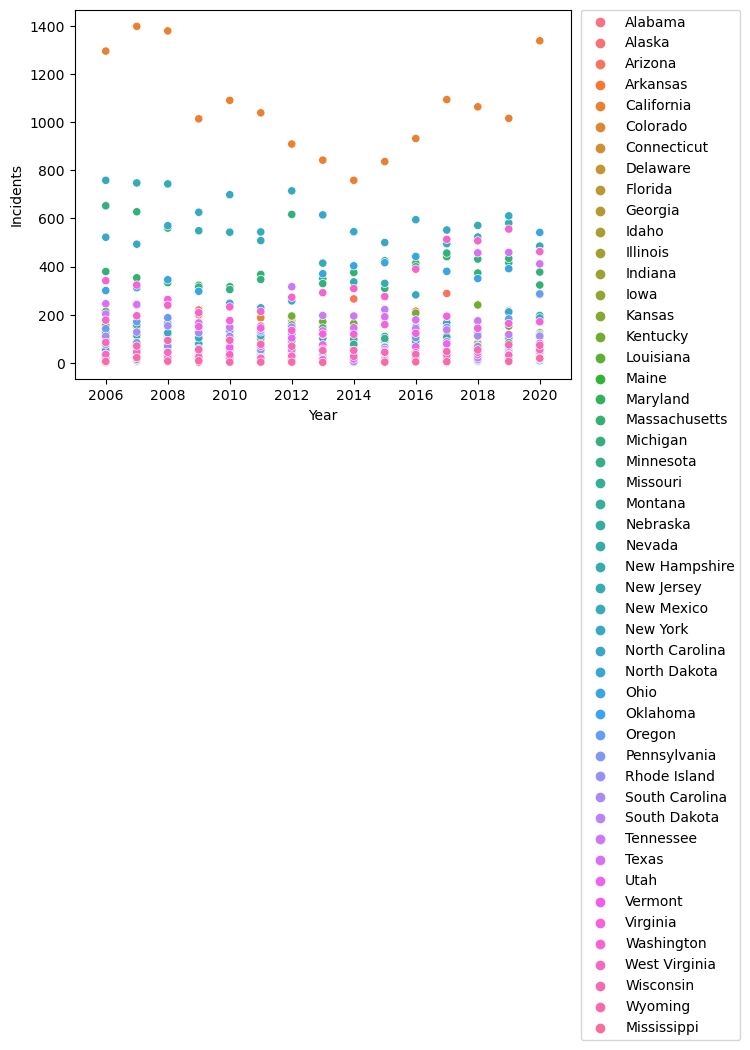

In [75]:
# Plot scatter plot Incidents X Year
ax = sns.scatterplot(data=df, x='Year', y='Incidents', hue='State')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlim(2005,2021)
plt.show()

### Preregistration statement
**Hypothesis 1**

Null: None of the predictor variables is useful in terms of predicting the number of state-wise hate crime incidents.
- β(population) =  β(GDP) = β(temperature) = 0 in all combinations of inputs.

Alternative: At least one of the predictor variables (population, GDP, temperature) is useful in terms of predicting the number of state-wise hate crime incidents.
- βi ≠ 0 (for i = population, GDP, temperature) in any one combination of inputs.

**Hypothesis 2**

Null: On top of the model above, before Covid or after doesn’t affect the number of state-wise hate crime incidents.
- β (is_covid)  = 0  

Alternative: Incidents of state-wise hate crimes increase with the presence of Covid.
- β (is_covid) ≠ 0

### Data analysis
First, we split our data into 85% training and 25% testing sets. 

In [76]:
train, test= train_test_split(df, test_size=0.25)

For Hypothesis 1, we have selected GDP, temperature, population, marriage rate, and education rate of the fifty states as potential candidates for building our multilinear regression model. Before conducting any regression, we used the training set to check the feasibility of multivariable linear regression of among our predictor variables. Specifically:
- Linearity: There's a linear relationship between predictors and response variables.
- Homoscedasticity: The variance of the residuals is constant.
- Multicollinearity: There should not be any multicollinearity in the data. The predictors should not be correlated with each other.

**Linearity check** We used scatter plots to check the linear relationship between the predictors and response variables. After we created the scatter plots, we recognized that the plots for population and GDP are non-linear. This means that these two predictors failed to meet the linearity assumption. Therefore, we decided to transform these predictors by taking the logarithm of these predictors before we fit them into our multilinear regression model. In future analysis, the population and GDP we referred to are actually log population and log GDP.

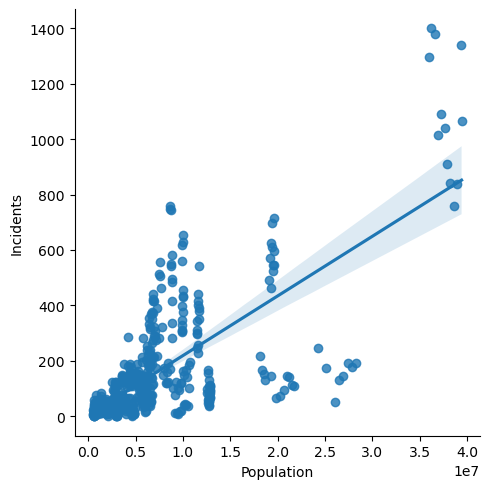

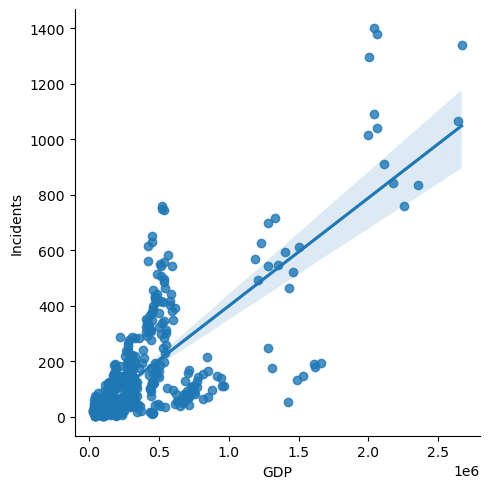

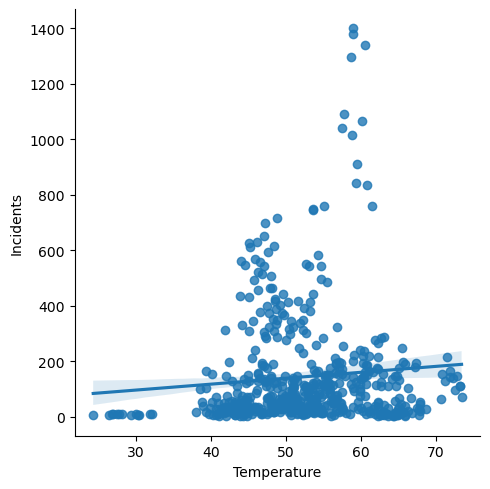

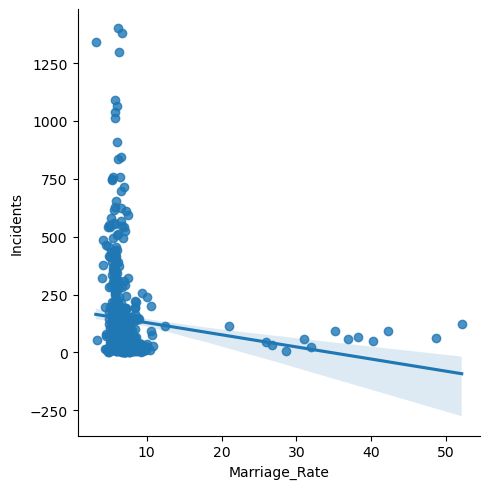

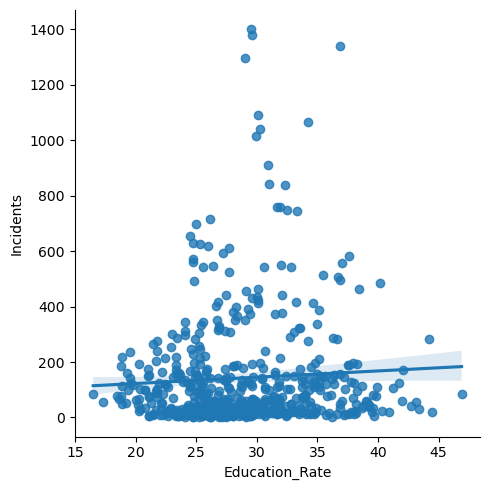

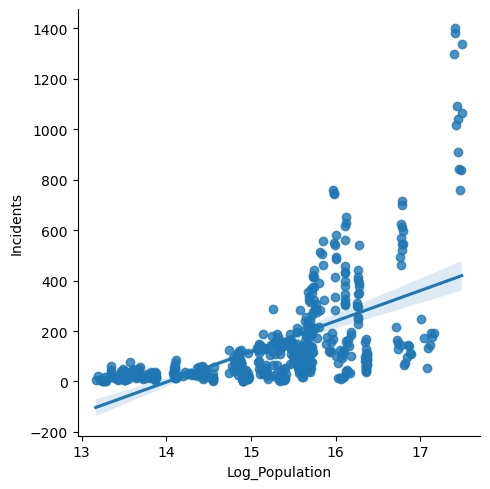

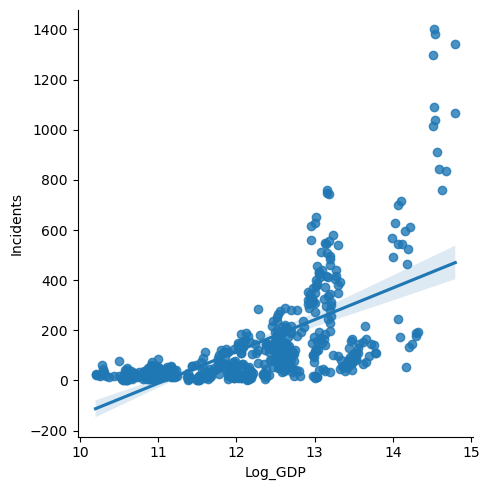

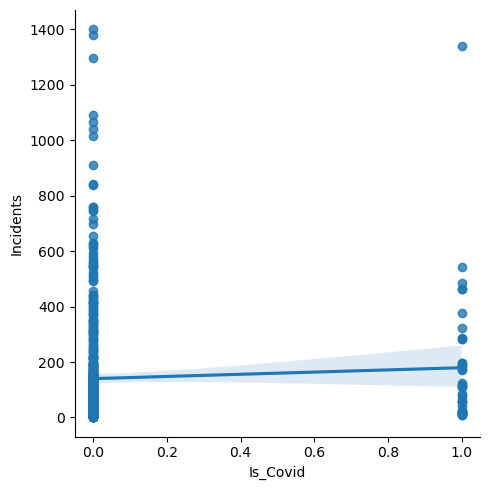

In [77]:
var = train.columns[[2,3,5,6,7,8,9,10]]
for v in var:
    sns.lmplot(data=train, x=v, y='Incidents')
    plt.show()

**Homoscedasticity check** We created a residual plot for each of the predictors to check homoscedasticity. The results show that the residual plots for population and GDP have an abnormal shape (parabola-like shape). This means that there’s heteroskedasticity between the response variables and each of the two predictors. Therefore, we transformed both predictors by taking the logarithm of the two predictors. The residual plots for the transformed predictors appear to be normal (no abnormal shape that suggests heteroskedasticity).

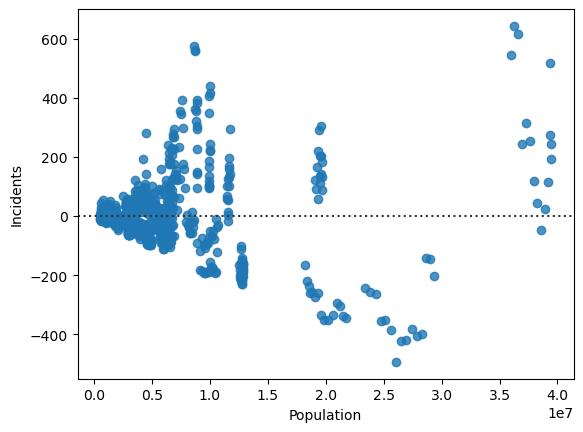

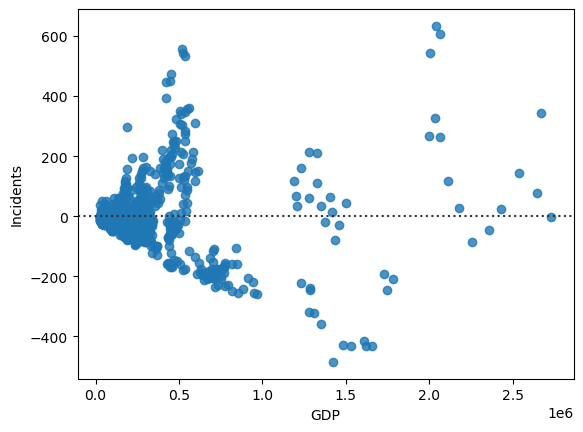

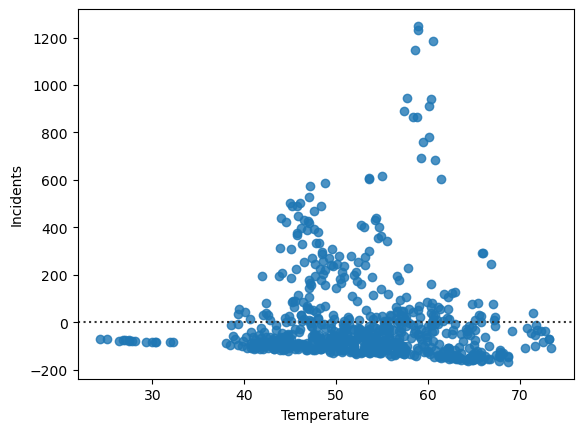

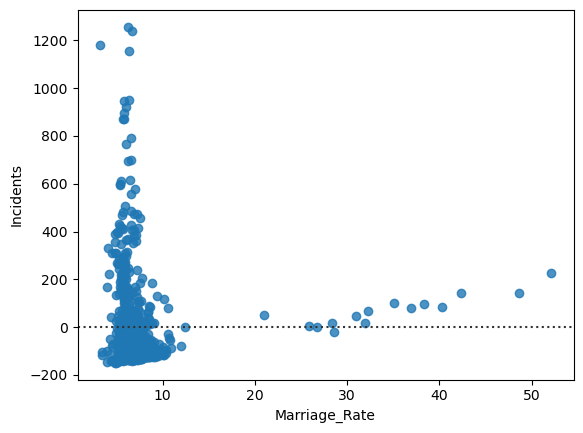

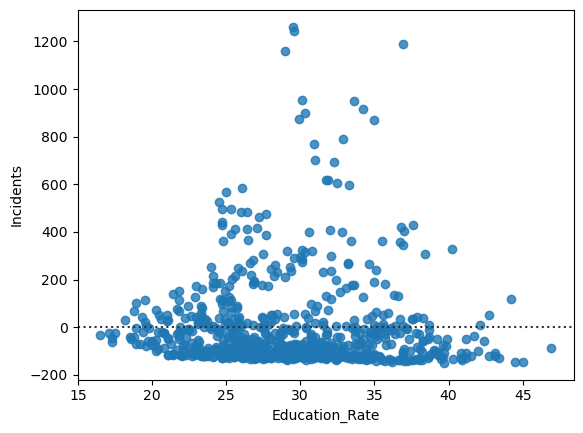

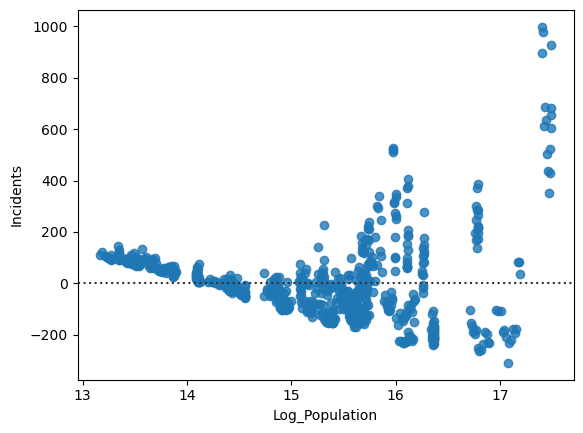

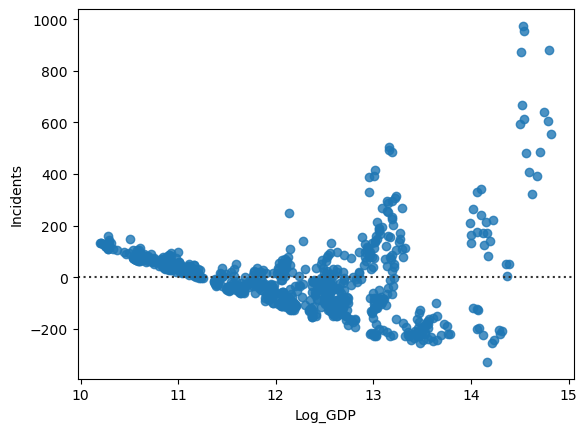

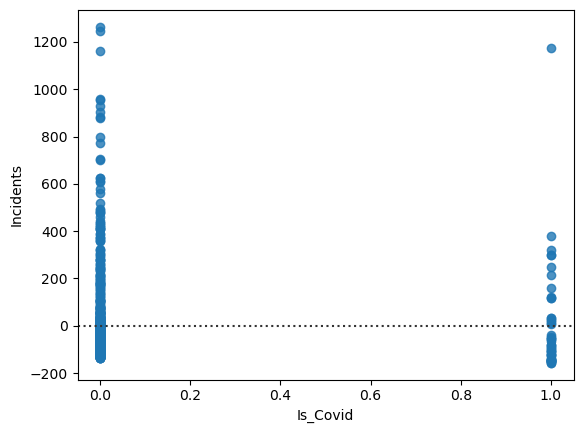

In [78]:
for v in var:
    # sns.residplot(data=df, x='Year', y=v)
    sns.residplot(data=df, x=v, y='Incidents')
    plt.show()

**Multicollinearity check** We used the correlation coefficient matrix to check for multicollinearity. The results show that there is a high positive correlation between log GDP and log population. The correlation coefficient between the two predictors is 0.981931, which is very close to one. Since there is a very high positive correlation between GDP and population, we should consider dropping one of the two predictors before we fit our multilinear regression model. By looking at the correlation coefficient matrix, we recognized that the population has the most coefficients with high absolute values. This means that the predictor is highly correlated with other predictor variables, so we decided to **drop the population predictor** before we run the multiple linear regression model.

In [79]:
df.iloc[:,5:].corr()

,Temperature,Marriage_Rate,Education_Rate,Log_Population,Log_GDP,Is_Covid
Temperature,1.000000,-0.019585,-0.172536,0.521346,0.443209,0.029190
Marriage_Rate,-0.019585,1.000000,-0.084587,-0.120524,-0.137006,-0.096028
Education_Rate,-0.172536,-0.084587,1.000000,-0.127990,-0.084375,0.230002
Log_Population,0.521346,-0.120524,-0.127990,1.000000,0.983259,0.009529
Log_GDP,0.443209,-0.137006,-0.084375,0.983259,1.000000,0.016853
Is_Covid,0.029190,-0.096028,0.230002,0.009529,0.016853,1.000000


### Data analysis & Evaluation of significance

**Hypothesis 1 Data analysis**

*Single variable models* 
- very small p-values, < 0.05, significant
- β(population) ≠  0, β(GDP) ≠ 0, β(temperature) ≠ 0 


In [80]:
var = ['Temperature', 'Log_GDP', 'Marriage_Rate', 'Education_Rate']
inc = train['Incidents']

# Anova F test for single variable selection
def anova(var):
    f = 'Incidents ~ ' + var
    d = smf.ols(formula=f, data=train)
    model = d.fit()
    a = sm.stats.anova_lm(model)
    print(a)

In [81]:
for v in var: anova(v)

                df        sum_sq        mean_sq         F    PR(>F)
Temperature    1.0  1.824022e+05  182402.175676  4.334967  0.037805
Residual     543.0  2.284778e+07   42076.947168       NaN       NaN
             df        sum_sq       mean_sq           F        PR(>F)
Log_GDP     1.0  9.422403e+06  9.422403e+06  375.988169  4.861554e-64
Residual  543.0  1.360778e+07  2.506037e+04         NaN           NaN
                  df        sum_sq        mean_sq        F   PR(>F)
Marriage_Rate    1.0  3.333043e+05  333304.299864  7.97397  0.00492
Residual       543.0  2.269688e+07   41799.042704      NaN      NaN
                   df        sum_sq       mean_sq         F    PR(>F)
Education_Rate    1.0  7.946989e+04  79469.887133  1.880209  0.170877
Residual        543.0  2.295071e+07  42266.509394       NaN       NaN


In [82]:
# Regression summary including coefficients and p-values
def summary(df, input):
    X = df[input]
    reg = sm.OLS(df['Incidents'], X).fit()
    print(reg.summary())

In [83]:
summary(train, ['Log_GDP'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.376
Model:                            OLS   Adj. R-squared (uncentered):              0.375
Method:                 Least Squares   F-statistic:                              327.9
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    1.04e-57
Time:                        22:59:19   Log-Likelihood:                         -3654.8
No. Observations:                 545   AIC:                                      7312.
Df Residuals:                     544   BIC:                                      7316.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [84]:
summary(test, ['Log_GDP'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.396
Model:                            OLS   Adj. R-squared (uncentered):              0.393
Method:                 Least Squares   F-statistic:                              118.6
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    1.44e-21
Time:                        22:59:19   Log-Likelihood:                         -1184.6
No. Observations:                 182   AIC:                                      2371.
Df Residuals:                     181   BIC:                                      2374.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [85]:
# Log likelihood ratio test for further models selection
def llr(base, add):
    X = train[add]
    model = sm.OLS(inc, X).fit()
    likelihood_ratio = -2*(base.llf - model.llf)
    log_likelihood_ratio = scipy.stats.chi2.sf(likelihood_ratio, 2)
    print(str(add) +'LLR = '+ str(log_likelihood_ratio))

In [86]:
g = sm.OLS(inc, train['Log_GDP']).fit()
llr(g, ['Log_GDP', 'Temperature'])
llr(g, ['Log_GDP', 'Marriage_Rate'])
llr(g, ['Log_GDP', 'Education_Rate'])

['Log_GDP', 'Temperature']LLR = 5.678908492592005e-10
['Log_GDP', 'Marriage_Rate']LLR = 4.2015005327067106e-05
['Log_GDP', 'Education_Rate']LLR = 5.965970941426123e-05


In [87]:
summary(train, ['Log_GDP', 'Temperature'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.423
Model:                            OLS   Adj. R-squared (uncentered):              0.421
Method:                 Least Squares   F-statistic:                              199.0
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    1.45e-65
Time:                        22:59:19   Log-Likelihood:                         -3633.5
No. Observations:                 545   AIC:                                      7271.
Df Residuals:                     543   BIC:                                      7280.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [88]:
summary(test, ['Log_GDP', 'Temperature'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.448
Model:                            OLS   Adj. R-squared (uncentered):              0.441
Method:                 Least Squares   F-statistic:                              72.90
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    6.43e-24
Time:                        22:59:19   Log-Likelihood:                         -1176.5
No. Observations:                 182   AIC:                                      2357.
Df Residuals:                     180   BIC:                                      2363.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [89]:
gt = sm.OLS(inc, train[['Log_GDP', 'Temperature']]).fit()
llr(gt, ['Log_GDP', 'Temperature', 'Marriage_Rate'])
llr(gt, ['Log_GDP', 'Temperature', 'Education_Rate'])

['Log_GDP', 'Temperature', 'Marriage_Rate']LLR = 0.00017036309685014773
['Log_GDP', 'Temperature', 'Education_Rate']LLR = 2.131097242721525e-06


In [90]:
summary(train, ['Log_GDP', 'Temperature', 'Education_Rate'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.450
Model:                            OLS   Adj. R-squared (uncentered):              0.447
Method:                 Least Squares   F-statistic:                              147.8
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    5.47e-70
Time:                        22:59:19   Log-Likelihood:                         -3620.4
No. Observations:                 545   AIC:                                      7247.
Df Residuals:                     542   BIC:                                      7260.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [91]:
summary(test, ['Log_GDP', 'Temperature', 'Education_Rate'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.488
Model:                            OLS   Adj. R-squared (uncentered):              0.479
Method:                 Least Squares   F-statistic:                              56.80
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    7.60e-26
Time:                        22:59:19   Log-Likelihood:                         -1169.6
No. Observations:                 182   AIC:                                      2345.
Df Residuals:                     179   BIC:                                      2355.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [92]:
gte = sm.OLS(inc, train[['Log_GDP', 'Temperature', 'Education_Rate']]).fit()
llr(gte, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate'])

['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate']LLR = 0.0002850335751064066


In [93]:
summary(train, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.466
Model:                            OLS   Adj. R-squared (uncentered):              0.462
Method:                 Least Squares   F-statistic:                              118.1
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    2.27e-72
Time:                        22:59:19   Log-Likelihood:                         -3612.3
No. Observations:                 545   AIC:                                      7233.
Df Residuals:                     541   BIC:                                      7250.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [94]:
summary(test, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.508
Model:                            OLS   Adj. R-squared (uncentered):              0.497
Method:                 Least Squares   F-statistic:                              45.90
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    1.87e-26
Time:                        22:59:19   Log-Likelihood:                         -1166.0
No. Observations:                 182   AIC:                                      2340.
Df Residuals:                     178   BIC:                                      2353.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

**Hypothesis 1 Evaluation of significance**

- Only when including all three variables, p-value of Temperature increases to 0.028 (but still within accepdf range), other p-values are all 0.
- Including all three variables (population, GDP, temperature) produces the highest Adjusted R-squared.

**Hypothesis 2 Data analysis**

- The confidence interval of β (Is_Covid) includes zero, so it's possible that β (Is_Covid) = 0. 
  - In comparison, although the predicted |β (Temperature)| (1.96) < |β (Is_Covid)| (21.53), since the confidence interval of β (Temperature) falls completelt below zero, it's unlikely that β (Temperature) = 0. 

- β (Is_Covid) is siginificanly smaller than |β (Log_population)| and |β (Log_GDP)|

In [95]:
gtme = sm.OLS(inc, train[['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate']]).fit()
llr(gtme, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid'])
summary(train, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid'])

['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid']LLR = 0.13242514252227816
                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.470
Model:                            OLS   Adj. R-squared (uncentered):              0.465
Method:                 Least Squares   F-statistic:                              95.84
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    3.60e-72
Time:                        22:59:19   Log-Likelihood:                         -3610.2
No. Observations:                 545   AIC:                                      7230.
Df Residuals:                     540   BIC:                                      7252.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     

In [96]:
summary(test, ['Log_GDP', 'Temperature', 'Education_Rate', 'Marriage_Rate', 'Is_Covid'])

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.508
Model:                            OLS   Adj. R-squared (uncentered):              0.494
Method:                 Least Squares   F-statistic:                              36.57
Date:                Mon, 21 Nov 2022   Prob (F-statistic):                    1.27e-25
Time:                        22:59:19   Log-Likelihood:                         -1165.9
No. Observations:                 182   AIC:                                      2342.
Df Residuals:                     177   BIC:                                      2358.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

**Hypothesis 2 Evaluation of significance**

- When binary covid indicator is included, p-value of Is_Covid is 0.812, larger than the accepdf threshold (0.05)
- Adding a binary covid indicator doesn't change the Adjusted R-squared significnatly. 

### Interpretation, Conclusions and Limitations

**Hypothesis 1**

Including all three variables (population, GDP, temperature) produces the best model to predict the number of state-wise hate crime incidents.

**Hypothesis 2**

On top of the model above, before Covid or after doesn’t significantly affect the number of state-wise hate crime incidents.
|β (is_covid)| is siginificanlt smaller than |β (Log_population)| and |β (Log_GDP)|

**Limitations**

Lacking domian expertise to select optimal variables to predict hate crime incidents.